In [ ]:
!pip install alibi

In [2]:
from alibi.explainers import AnchorTabular, CounterFactualProto
from alibi.utils.mapping import ohe_to_ord, ord_to_ohe

In [ ]:
!pip install witwidget

In [4]:
import witwidget
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

In [ ]:
!pip install catboost shap

In [6]:
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from catboost import CatBoostClassifier
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from alibi.utils.mapping import ohe_to_ord, ord_to_ohe
from alibi.explainers import AnchorTabular, CounterfactualProto
import shap
import witwidget
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

In [ ]:
!pip install machine_learning_datasets

In [8]:
import machine_learning_datasets as mldatasets

In [9]:
tf.compat.v1.disable_eager_execution()
print(tf.executing_eagerly())

False


In [10]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
recidivism_df = pd.read_csv('/content/drive/My Drive/Explainable ML/recidivism-risk.csv', sep=',')

In [12]:
recidivism_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     1001 non-null   int64  
 1   age                    1001 non-null   int64  
 2   juv_fel_count          1001 non-null   int64  
 3   juv_misd_count         1001 non-null   int64  
 4   juv_other_count        1001 non-null   int64  
 5   priors_count           1001 non-null   int64  
 6   is_recid               1001 non-null   int64  
 7   compas_score           1001 non-null   int64  
 8   sex_Female             1001 non-null   float64
 9   sex_Male               1001 non-null   float64
 10  race_African-American  1001 non-null   float64
 11  race_Asian             1001 non-null   float64
 12  race_Caucasian         1001 non-null   float64
 13  race_Hispanic          1001 non-null   float64
 14  race_Other             1001 non-null   float64
 15  c_ch

In [13]:
recidivism_df.age.describe()

count    1001.000000
mean       33.753247
std        11.456354
min        18.000000
25%        25.000000
50%        31.000000
75%        39.000000
max        78.000000
Name: age, dtype: float64

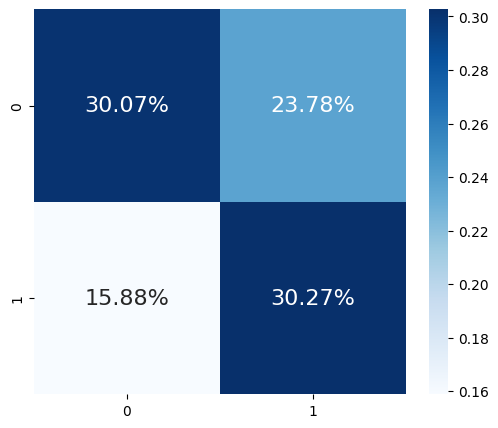

In [14]:
cf_matrix = metrics.confusion_matrix(recidivism_df.is_recid,\
                                     recidivism_df.compas_score)
plt.figure(figsize=(6, 5))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,\
            fmt='.2%', cmap='Blues', annot_kws={'size':16})
plt.show()

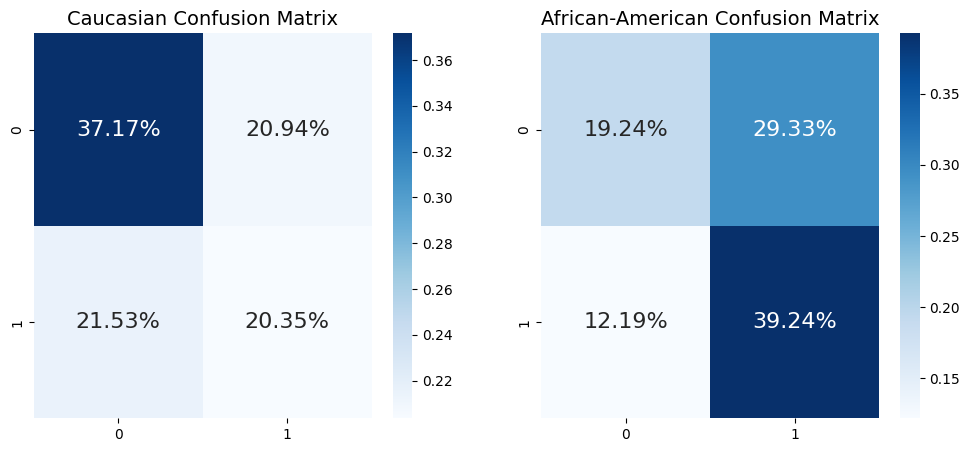

	African-American FPR:	60.4%
	Caucasian FPR:		36.0%
	Ratio FPRs:		1.68 x


In [15]:
recidivism_c_df = recidivism_df[recidivism_df['race_Caucasian'] == 1]
recidivism_aa_df = recidivism_df[recidivism_df['race_African-American'] == 1]

_ = mldatasets.\
      compare_confusion_matrices(recidivism_c_df.is_recid,
                                 recidivism_c_df.compas_score,\
                                 recidivism_aa_df.is_recid,\
                                 recidivism_aa_df.compas_score,\
                                 'Caucasian', 'African-American', compare_fpr=True)

In [16]:
rand = 9
np.random.seed(rand)

y = recidivism_df['compas_score']
X = recidivism_df.drop(['compas_score', 'is_recid', 'ID'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand)

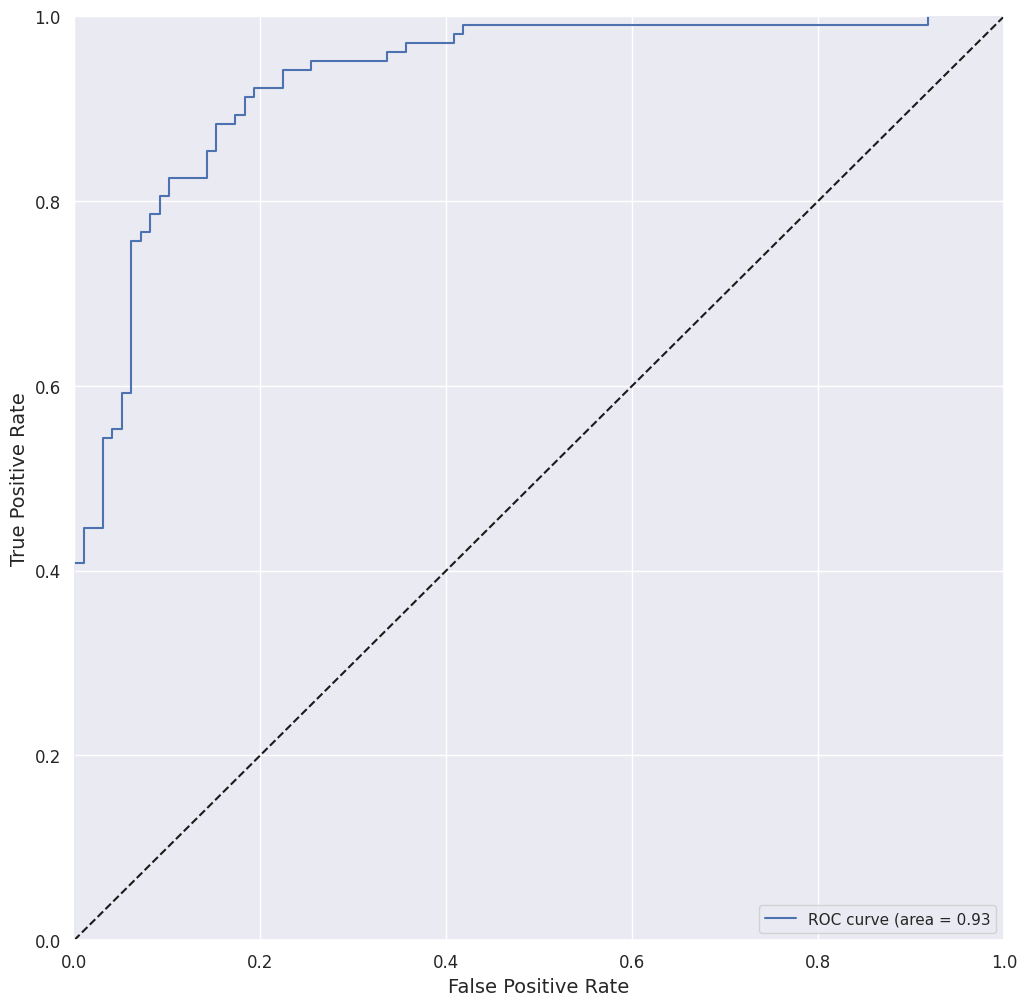

Accuracy_train:  0.9850		Accuracy_test:   0.8607
Precision_test:  0.8440		Recall_test:     0.8932
ROC-AUC_test:    0.9318		F1_test:         0.8679		MCC_test: 0.7221


In [17]:
orig_plt_params = plt.rcParams
sns.set()
cb_mdl = CatBoostClassifier(iterations=500, learning_rate=0.5, depth=8)
fitted_cb_mdl = cb_mdl.fit(X_train, y_train, verbose=False)
y_train_cb_pred, y_test_cb_prob, y_test_cb_pred =\
        mldatasets.evaluate_class_mdl(fitted_cb_mdl, X_train,\
                                      X_test, y_train, y_test)

In [ ]:
!pip install plot-keras-history

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


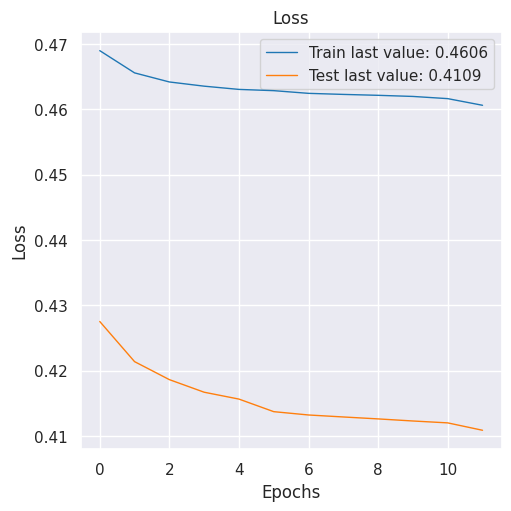

In [19]:
fitted_nn_mdl = tf.keras.Sequential([tf.keras.Input(shape=[len(X_train.keys())]),
                                     tf.keras.layers.Dense(7, activation='relu'),
                                     tf.keras.layers.Dense(1, activation='sigmoid')
                                     ])

fitted_nn_mdl.compile(loss='mean_squared_error', optimizer='adam')
nn_history = fitted_nn_mdl.fit(X_train.values, y_train.values, epochs=12, batch_size = 32, validation_split=0.2, verbose=0)


from plot_keras_history import show_history, plot_history
show_history(nn_history)
plot_history(nn_history)
plt.close()

In [20]:
idx1 = 2
idx2 = 503
idx3 = 57
eval_idxs = X_test.index.isin([idx1, idx2, idx3])
X_test_eval = X_test[eval_idxs]
eval_df = pd.concat([pd.DataFrame({'y': y_test[eval_idxs]}, index=[idx3, idx2, idx1]), \
                     pd.DataFrame({'y_pred': y_test_cb_pred[eval_idxs]}, index=[idx3, idx2, idx1]), X_test_eval], axis=1).transpose()
print(eval_df)

                        57    503   2  
y                       0.0   1.0   1.0
y_pred                  1.0   0.0   1.0
age                    24.0  47.0  31.0
juv_fel_count           0.0   0.0   0.0
juv_misd_count          0.0   0.0   0.0
juv_other_count         0.0   0.0   0.0
priors_count            1.0  23.0   0.0
sex_Female              0.0   0.0   0.0
sex_Male                1.0   1.0   1.0
race_African-American   0.0   1.0   0.0
race_Asian              0.0   0.0   0.0
race_Caucasian          0.0   0.0   1.0
race_Hispanic           1.0   0.0   0.0
race_Other              0.0   0.0   0.0
c_charge_degree_(F1)    0.0   0.0   0.0
c_charge_degree_(F2)    0.0   0.0   0.0
c_charge_degree_(F3)    1.0   0.0   0.0
c_charge_degree_(F7)    0.0   0.0   0.0
c_charge_degree_(M1)    0.0   1.0   0.0
c_charge_degree_(M2)    0.0   0.0   0.0
c_charge_degree_(MO3)   0.0   0.0   0.0
c_charge_degree_(X)     0.0   0.0   0.0
c_charge_degree_nan     0.0   0.0   1.0


In [21]:
class_names = ['Low Risk', 'Medium/High Risk']

In [36]:
X_test_eval = np.expand_dims(X_test.values[X_test.\
                                           index.get_loc(idx2)], axis=0)
print(X_test_eval)

[[47.  0.  0.  0. 23.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
   0.  0.  0.]]


In [23]:
cat_vars_ohe = {5: 2, 7: 5, 12: 9}
print(ohe_to_ord(X_test_eval, cat_vars_ohe)[0])

[[31.  0.  0.  0.  0.  1.  2.  8.]]


In [24]:
category_map = {
    5: ['Female', 'Male'],
    6: ['African-American', 'Asian', 'Caucasian',\
        'Hispanic', 'Native American', 'Other'],
    7: ['Felony 1st Degree', 'Felony 2nd Degree',\
        'Felony 3rd Degree', 'Felony 7th Degree',\
        'Misdemeanor 1st Degree', 'Misdemeanor 2nd Degree',\
        'Misdemeanor 3rd Degree', 'Other Charge Degree']
}
feature_names = ['age', 'juv_fel_count', 'juv_misd_count',\
                 'juv_other_count', 'priors_count',
                 'sex', 'race', 'c_charge_degree']

In [25]:
category_map_ohe = {5: ['Not Female', 'Female'], 6: ['Not Male', 'Male'],\
        7:['Not African American', 'African American'],\
        8:['Not Asian', 'Asian'], 9:['Not Caucasian', 'Caucasian'],\
        10:['Not Hispanic', 'Hispanic'],\
        11:['Not Native American', 'Native American'],\
        12:['Not Other Race', 'Other Race'],\
        13:['Not Felony 1st Level', 'Felony 1st Level'],\
        14:['Not Felony 2nd Level', 'Felony 2nd Level'],\
        15:['Not Felony 3rd Level', 'Felony 3rd Level'],\
        16:['Not Felony 7th Level', 'Felony 7th Level'],\
        17:['Not Misdemeanor 1st Deg', 'Misdemeanor 1st Deg'],\
        18:['Not Misdemeanor 2nd Deg', 'Misdemeanor 2nd Deg'],\
        19:['Not Misdemeanor 3rd Deg', 'Misdemeanor 3rd Deg'],\
        20:['Not Other Charge Degree', 'Other Charge Degree']}

In [37]:
predict_cb_fn = lambda x: fitted_cb_mdl.predict_proba(x)
anchor_cb_explainer = AnchorTabular(predict_cb_fn, X_train.columns,\
                                    categorical_names=category_map_ohe)
anchor_cb_explainer.fit(X_train.values)

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (25, 50, 75)},
  'version': '0.9.4'}
)

In [38]:
print('Prediction: %s' %\
      class_names[anchor_cb_explainer.predictor(X_test.loc[idx2].values)[0]])


Prediction: Medium/High Risk


In [28]:
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[idx1].values, threshold=0.9,\
                                seed=rand)
print('Anchor: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Anchor: 25.00 < age <= 31.00 AND
	sex_Female = Not Female AND
	c_charge_degree_(M1) = Not Felony 7th Level AND
	race_Hispanic = Not Hispanic AND
	c_charge_degree_(M2) = Not Misdemeanor 1st Deg AND
	c_charge_degree_(F3) = Not Felony 2nd Level AND
	c_charge_degree_nan = Other Charge Degree AND
	race_Caucasian = Caucasian AND
	sex_Male = Male AND
	c_charge_degree_(X) = Not Misdemeanor 3rd Deg AND
	race_Other = Not Native American AND
	c_charge_degree_(F2) = Not Felony 1st Level AND
	c_charge_degree_(F1) = Not Other Race AND
	race_Asian = Not Asian AND
	c_charge_degree_(F7) = Not Felony 3rd Level AND
	c_charge_degree_(MO3) = Not Misdemeanor 2nd Deg AND
	juv_fel_count <= 0.00 AND
	priors_count <= 0.00
Precision: 0.981
Coverage: 0.001


In [29]:
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[idx2].values, threshold=0.9,\
                                seed=rand)
print('Anchor: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Anchor: priors_count > 5.00 AND
	race_African-American = African American AND
	sex_Female = Not Female
Precision: 0.902
Coverage: 0.131


In [30]:
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[idx3].values, threshold=0.9,\
                                seed=rand)
print('Anchor: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Anchor: priors_count <= 2.00 AND
	race_African-American = Not African American AND
	race_Hispanic = Hispanic AND
	juv_other_count <= 0.00 AND
	c_charge_degree_(F3) = Felony 2nd Level AND
	juv_fel_count <= 0.00 AND
	juv_misd_count <= 0.00 AND
	race_Other = Not Native American AND
	c_charge_degree_(M2) = Not Misdemeanor 1st Deg AND
	c_charge_degree_(X) = Not Misdemeanor 3rd Deg AND
	c_charge_degree_nan = Not Other Charge Degree AND
	c_charge_degree_(F1) = Not Other Race AND
	race_Asian = Not Asian
Precision: 0.885
Coverage: 0.018


In [31]:
feature_range = (X_train.values.min(axis=0).reshape(1,21).astype(np.float32),\
                 X_train.values.max(axis=0).reshape(1,21).astype(np.float32))
print(feature_range)

(array([[18.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32), array([[78.,  3., 12.,  4., 36.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]], dtype=float32))


In [32]:
np.random.seed(rand)
tf.random.set_seed(rand)
cf_cb_explainer = CounterfactualProto(predict_cb_fn,
                                    X_test_eval.shape,
                                    max_iterations=100,
                                    feature_range=feature_range,
                                    beta=.1, theta=100,\
                                    use_kdtree=True
                                )
cf_cb_explainer.fit(X_test.values, d_type='abdm-mvdm')

CounterfactualProto(meta={
  'name': 'CounterfactualProto',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'kappa': 0.0,
              'beta': 0.1,
              'gamma': 0.0,
              'theta': 100,
              'cat_vars': None,
              'ohe': False,
              'use_kdtree': True,
              'learning_rate_init': 0.01,
              'max_iterations': 100,
              'c_init': 10.0,
              'c_steps': 10,
              'eps': (0.001, 0.001),
              'clip': (-1000.0, 1000.0),
              'update_num_grad': 1,
              'write_dir': None,
              'feature_range': (array([[18.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32), array([[78.,  3., 12.,  4., 36.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]], dtype=float32)),
              'shape': (1, 21),
              'is

In [33]:
X_test_eval = np.expand_dims(X_test.values[X_test.index.get_loc(idx2)], axis=0)
print("X_test_eval\n",X_test_eval)

X_test_eval
 [[47.  0.  0.  0. 23.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
   0.  0.  0.]]


In [34]:
cf_cb_explanation = cf_cb_explainer.explain(X_test_eval)

In [35]:
print("cf_nn_explanation.data['cf']['X']\n",cf_cb_explanation.data['cf']['X'])

cf_nn_explanation.data['cf']['X']
 [[45.404408    0.          0.          0.          8.533128    0.
   1.          0.39451188  0.          0.60548806  0.          0.
   0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]]
